In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle

import scipy.stats as stats

# check out https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.errorbar.html#matplotlib.axes.Axes.errorbar
# for plot of numerous experiments with same settings

exp_path = "experiments/" + "cdr50_percRange001_010"
if os.path.isfile(
        exp_path + "/simulated_data_shortage_output.csv"):  # check whether we have just a single experiment, or a collection 
    data = [pd.read_csv(exp_path + "/simulated_data_shortage_output.csv")]
else:
    data = [pd.read_csv(exp_path + "/" + path + "/simulated_data_shortage_output.csv") for path in
            os.listdir(exp_path + "/") if not (path.endswith(".csv") or path.endswith(".pickle") or path.endswith(".gitignore"))]

In [2]:
# disc_performances = [[number for number in sample["optic_disc_performance"]] for sample in data]
# cup_performances = [[number for number in sample["optic_cup_performance"]] for sample in data]

disc_performances = [[float(number[7:-1]) for number in sample["optic_disc_performance"]] for sample in data]
cup_performances = [[float(number[7:-1]) for number in sample["optic_cup_performance"]] for sample in data]
percentages = [round(float(perc), 3) for perc in
               data[0]["percentage"]]  # assuming that all experiments were run with the same percentages

In [3]:
disc_performances = np.array(disc_performances)
cup_performances = np.array(cup_performances)

In [4]:
disc_performances

array([[0.8877, 0.7878, 0.9197, 0.923 , 0.9154, 0.9349, 0.9352, 0.9126,
        0.9127, 0.9285],
       [0.5794, 0.9145, 0.8981, 0.9284, 0.9302, 0.9366, 0.9316, 0.9354,
        0.9357, 0.9293],
       [0.81  , 0.8813, 0.9324, 0.9191, 0.9331, 0.9363, 0.9323, 0.8896,
        0.9297, 0.9042],
       [0.1607, 0.902 , 0.9247, 0.9296, 0.9261, 0.899 , 0.8712, 0.94  ,
        0.9172, 0.9384]])

In [5]:
summary_frame = pd.DataFrame(
    np.array([percentages, disc_performances.mean(axis=0), disc_performances.std(axis=0), cup_performances.mean(axis=0),
              cup_performances.std(axis=0)]).T,
    columns=["percentages", "disc_performance_mean", "disc_performance_std", "cup_performance_mean",
             "cup_performance_std"]
)
summary_frame.to_csv(exp_path + "/summary.csv")

In [6]:
cup_performances.mean(axis=0)

array([0.0938  , 0.097525, 0.1168  , 0.116025, 0.027275, 0.114475,
       0.06145 , 0.208575, 0.266275, 0.0245  ])

In [7]:
whole_data = {"percentages": percentages, "disc_performance": disc_performances, "cup_performance": cup_performances}
with open(exp_path + "/whole_data.pickle", "wb") as handle:
    pickle.dump(whole_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

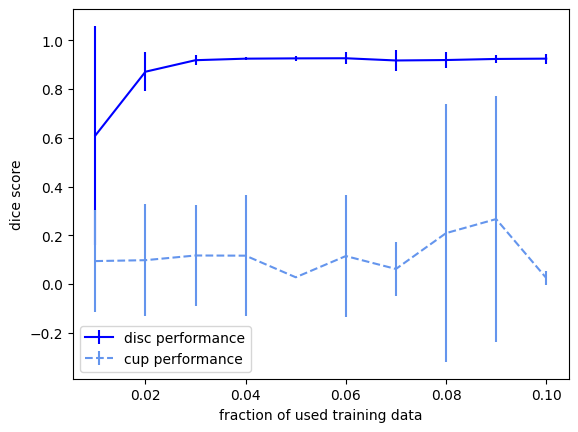

In [8]:
alpha = 0.05  # alpha level for confidence intervals

plt.errorbar(percentages,
             disc_performances.mean(axis=0),
             yerr=stats.t.ppf(1 - alpha / 2, df=(len(data) - 1)) / (len(data) ** (1 / 2)) * disc_performances.std(
                 axis=0),
             linestyle="-", color="b", label="disc performance")
plt.errorbar(percentages,
             cup_performances.mean(axis=0),
             yerr=stats.t.ppf(1 - alpha / 2, df=(len(data) - 1)) / (len(data) ** (1 / 2)) * cup_performances.std(
                 axis=0),
             linestyle="--", color="cornflowerblue", label="cup performance")
# plt.plot(percentages, disc_performance, linestyle="-", color="b", label="disc performance")
# plt.plot(percentages, cup_performance, linestyle="--", color="b", label="cup performance")
plt.xlabel("fraction of used training data")
plt.ylabel("dice score")
plt.legend()

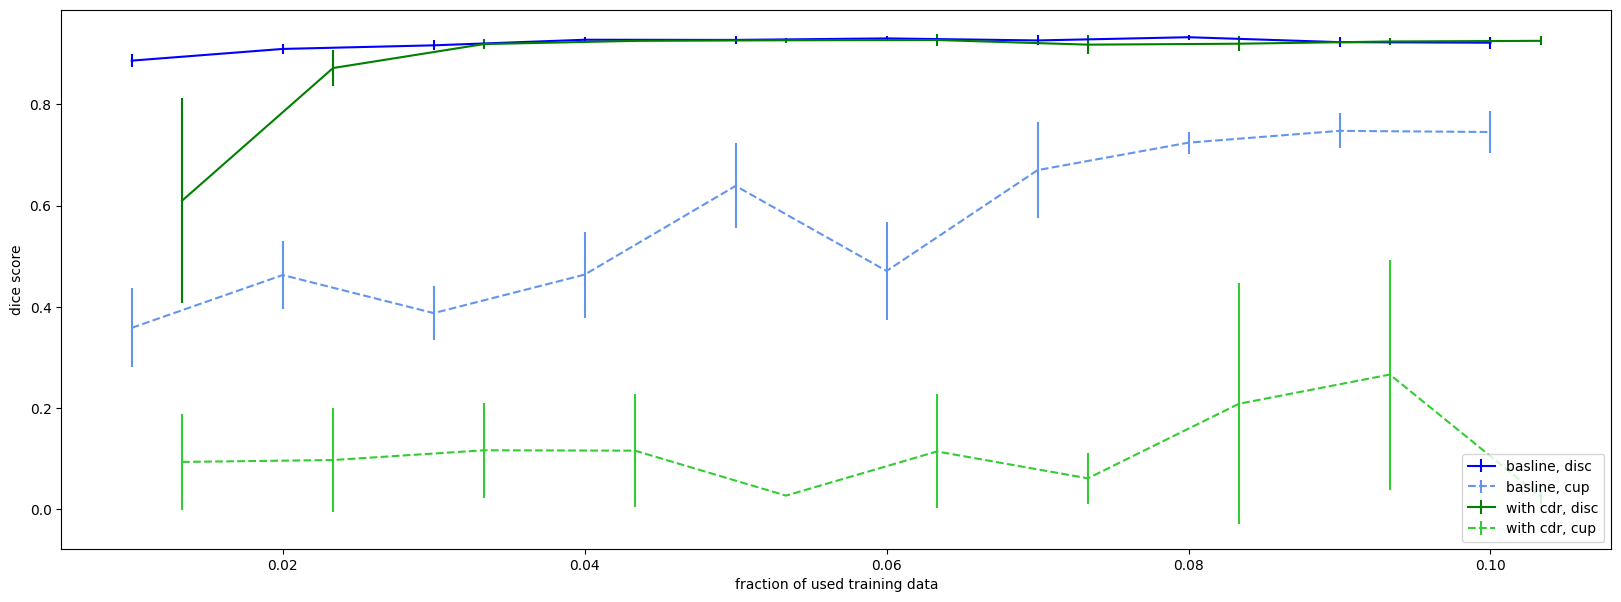

In [9]:
experiments_of_interest = ["standard_percRange001_010", "cdr50_percRange001_010"]
experiments_labels = ["basline", "with cdr", "topological loss, very narrow"]
# experiments_colors = [("b", "cornflowerblue"), ("green", "limegreen")]
experiments_colors = [("b", "cornflowerblue"), ("green", "limegreen"), ("orangered", "coral")]
exp_paths = ["experiments/" + name for name in experiments_of_interest]

plt.rcParams["figure.figsize"] = (20,7)

for i in range(len(experiments_of_interest)):
    data = pd.read_csv(exp_paths[i] + "/summary.csv")
    plt.errorbar(data["percentages"]+i/300,
                 data["disc_performance_mean"],
                 yerr=stats.t.ppf(1 - alpha / 2, df=(len(data) - 1)) / (len(data) ** (1 / 2)) * data["disc_performance_std"],
                 linestyle="-", color=experiments_colors[i][0], label=experiments_labels[i] + ", disc")
    plt.errorbar(data["percentages"]+i/300,
                 data["cup_performance_mean"],
                 yerr=stats.t.ppf(1 - alpha / 2, df=(len(data) - 1)) / (len(data) ** (1 / 2)) * data["cup_performance_std"],
                 linestyle="--", color=experiments_colors[i][1], label=experiments_labels[i] + ", cup")

plt.xlabel("fraction of used training data")
plt.ylabel("dice score")
plt.legend(loc=4) # loc 4 ... lower right
plt.show()

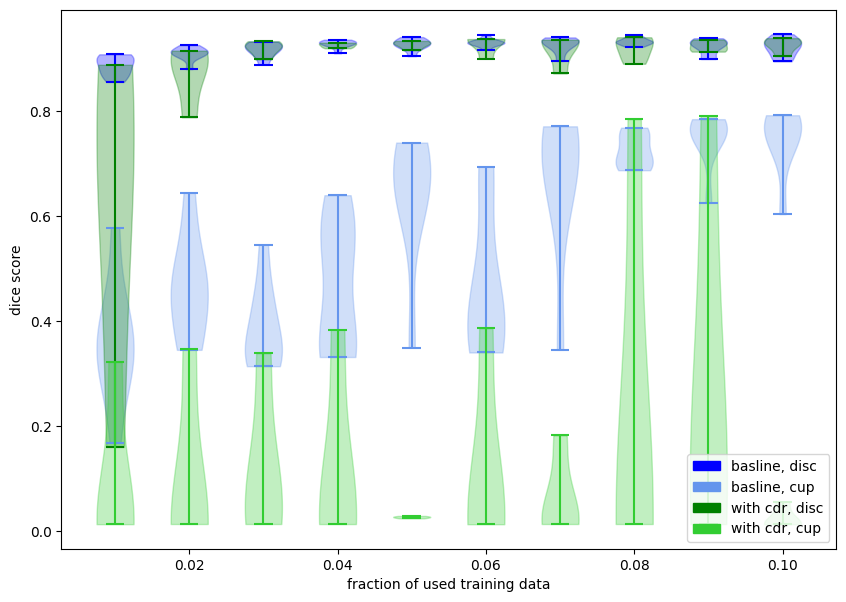

In [10]:
patches = []
labels = []
plt.rcParams["figure.figsize"] = (10,7)
width = 0.005

for i in range(len(experiments_of_interest)):
    with open(exp_paths[i] + "/whole_data.pickle", "rb") as handle:
        data = pickle.load(handle)
    violin = plt.violinplot(data["disc_performance"],
                            positions = data["percentages"],
                            widths=width) # widths depends on the percentage area we look at
    for pc in violin['bodies']:
        pc.set_facecolor(experiments_colors[i][0])
        pc.set_edgecolor(experiments_colors[i][0])
    for partname in ('cbars','cmins','cmaxes'):
        vp = violin[partname]
        vp.set_edgecolor(experiments_colors[i][0])
    patches.append(mpatches.Patch(color=experiments_colors[i][0]))
    labels.append(experiments_labels[i] + ", disc")
    
    violin = plt.violinplot(data["cup_performance"],
                            positions = data["percentages"],
                            widths=width) # widths depends on the percentage area we look at
    for pc in violin['bodies']:
        pc.set_facecolor(experiments_colors[i][1])
        pc.set_edgecolor(experiments_colors[i][1])
    for partname in ('cbars','cmins','cmaxes'):
        vp = violin[partname]
        vp.set_edgecolor(experiments_colors[i][1])
    patches.append(mpatches.Patch(color=experiments_colors[i][1]))
    labels.append(experiments_labels[i] + ", cup")


plt.xlabel("fraction of used training data")
plt.ylabel("dice score")
plt.legend(patches, labels, loc=4) # loc 4 ... lower right
plt.show()